# African Airlines Sentiment Analysis (2015-Present)
**Modelling & (Aspect Based) Sentiment Analysis V1**

### 1. Library Importation

**aspect-based-sentiment-analysis (ABSA)** package can be viewed [here](https://github.com/ScalaConsultants/Aspect-Based-Sentiment-Analysis)

In [277]:
import pandas as pd
import numpy as np
import aspect_based_sentiment_analysis as absa

### 2. Loading the data

In [278]:
#Dataframe with review text cleaned and encoded sentiment values
airlines_df = pd.read_csv('../data/processed/partial_encoding.csv',index_col=0)

#Convert encoded rating sentiment values to int
airlines_df.iloc[:,6:13] = airlines_df.iloc[:,6:13]

In [279]:
airlines_df.head(3)

,Subject,date_published,review_text,type_of_traveller,seat_type,date_flown,seat_comfort,cabin_staff_service,food_&_beverages,inflight_entertainment,ground_service,wifi_&_connectivity,value_for_money,recommended
0,ethiopian-airlines,2021-01-31 00:08:00,ive flown ethiopian airlines couple times gene...,Business,Economy Class,August 2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,ethiopian-airlines,2021-01-06 00:08:00,fantastic journey flew q turbo prop khartoum a...,Solo Leisure,Economy Class,July 2021,2.0,2.0,2.0,2.0,2.0,NaN,2.0,1
2,ethiopian-airlines,2021-01-29 00:07:00,children stuck transit ethiopia ethiopian airl...,Family Leisure,Economy Class,July 2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### 3. Quick ABSA

In [280]:
nlp = absa.load()

Some layers from the model checkpoint at absa/classifier-rest-0.2 were not used when initializing BertABSClassifier: ['dropout_379']
- This IS expected if you are initializing BertABSClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertABSClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of BertABSClassifier were not initialized from the model checkpoint at absa/classifier-rest-0.2 and are newly initialized: ['dropout_189']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [281]:
#Note down the possible aspect classes
aspect_classes = {'seat':['seat'], 'cabin_staff_service': ['crew', 'service', 'staff', 'attendant'], 
                  'food': ['food','meal'],
                  'inflight_entertainment': ['entertainment','movies','shows'], 
                  'ground_service': ['ground service'], 'wifi': ['wifi']}

In [282]:
def reviews_absa(df,sample_num = None):
    
    #Dataframe to store the eventual sentiment for different aspects
    sentiment_df = pd.DataFrame()
    
    #Generate random number which will serve as selections for review texts
    rand_idx = np.random.randint(0,len(df),sample_num)

    #Iterate through all the aspects
    for aspect_class in aspect_classes.keys():

        #print('aspect class', aspect_class,'\n')

        #List to store the aspect sentiment for each review for a given aspect
        review_aspect_sentiment = []

        #Iterate through all the reviews
        for review in df.review_text.iloc[rand_idx]:

            #print('review:',review,'\n')

            #List to store the avg sentiment for all relevant aspect terms
            term_sentiments = []

            #Iterate through all the aspect terms for an aspect
            for aspect_term in aspect_classes[aspect_class]:

                #print('aspect_term:',aspect_term,'\n')

                #If the term is in the review
                if aspect_term in review:

                    try:
                        #Calculate the aspect sentiment
                        sent = nlp(review,aspects = [aspect_term])

                        #Append the sentiment score to the sentiment scores list
                        term_sentiments.append(np.array(sent.subtasks[aspect_term].examples[0].scores))

                    except:

                        pass


                #If the term is not in the review, pass
                else:
                    pass

            #If there were multiple aspect terms, find the average sentiment values across all terms
            #Note: This is reported in the form [neutral,negative,positive]
            if len(term_sentiments) > 1:

                avg_sentiments = np.array(term_sentiments).mean(axis=0)

            #If just one, no need to find the average
            elif len(term_sentiments) == 1:

                avg_sentiments = np.array(term_sentiments)

            #If len == 0, no review with the aspect terms was found
            else:
                avg_sentiments = None

            #If avg_sentiment is None, append np.nan indicating no sentiment for the aspect
            if avg_sentiments is None:

                review_aspect_sentiment.append(np.nan)

            else:

                #Get the sentiment category (neutral,negative,positive) with the largest probability
                max_idx = np.argmax(avg_sentiments)

                if max_idx == 2:

                    review_aspect_sentiment.append(2)

                elif max_idx == 1:

                    review_aspect_sentiment.append(0)

                else:

                    review_aspect_sentiment.append(1)


            #print(review_aspect_sentiment, '\n\n')

        sentiment_df[aspect_class] = review_aspect_sentiment
        
    return rand_idx, sentiment_df, df.iloc[rand_idx,6:12]


In [283]:
def replace_nan_with_str(df,true_df):

    #Iterate through all the values in the sentiment dataframe
    for row in range(len(df)):

        for col in range(len(df.columns)):

            #If there was no sentiment prediction from the model (i.e. if np.nan)
            if df.iloc[row,col] not in [*range(3)]:

                #Replace the nan prediction with a string (since np.nans cannot be compared with each other)
                df.iloc[row,col] = str(df.iloc[row,col])

                #Replace the review sentiment with a None - allowing us compare all available prediction 
                #to actual reported values
                true_df.iloc[row,col] = str(np.nan)
              
    
    return df,true_df

In [284]:
def absa_evaluation(true_df,num_reviews):
    
    #Run aspect based sentiment analysis on num_reviews randomly selected reviews
    _ , sentiment_df, reviews_ratings = reviews_absa(true_df,num_reviews)
    
    #Reprocess in preparation for prediction comparison
    #Here we reformat so only aspects that the model detected and predicted are evaluated
    sentiment_df, reviews_ratings = replace_nan_with_str(sentiment_df, reviews_ratings)
    
    #Calculate the number of predictions
    num_preds = np.array([1 for pred in sentiment_df.values.flatten() if pred != 'nan']).sum()
    
    #Compare predictions to user reported sentiment values 
    comparison_vals = (sentiment_df.values == reviews_ratings.values).flatten()

    #Compute and return the number of predictions and the accuracy
    return num_preds, (comparison_vals.sum()/len(comparison_vals))
    

In [285]:
#List to store accuracy values
accuracy_values = []

#Counter to track total number of (effective) model predictions
num_predictions = 0

#Repeat absa evaluation for 5 runs (corresponding to 250 reviews)
for _ in range(5):
    
    num_pred, accuracy = absa_evaluation(airlines_df,50)
    
    num_predictions += num_pred
    
    accuracy_values.append(accuracy)
    
print(f"Total number of predictions: {num_predictions}")
print(f"Average accuracy: {np.array(accuracy_values).mean()}")


Total number of predictions: 504
Average accuracy: 0.8726666666666667


### How well does the current model detect referenced aspects in reviews?

In [248]:
#Load the original data so we can see the original review texts (with no text processing)
original_df = pd.read_csv('../data/interim/airlines_categorical.csv',index_col=0)

#Run the ABSA to get the aspects and the model prediction for the deduced aspects
rand_idx, sentiment_df, reviews_ratings = reviews_absa(airlines_df,5)

#Replace the aspect predictions which are currently integers with interpretable text
sentiment_df.replace({0.0:'Negative', 1.0:'Neutral', 2.0: 'Positive'},inplace=True)

#Print the text, the aspects and the models prediction for the aspects
for idx,value in enumerate(rand_idx):
    
    print('Text', idx+1,':')
    print(original_df.iloc[value,2], '\n')
    
    for attr, pred in zip(sentiment_df.iloc[idx].index,sentiment_df.iloc[idx].values):
        print('- ',attr,': ',pred)
        
    print('\n')
    
    

Text 1 :
i bought a ticket madrid to cairo. i requested a refund due to not being able to travel in march 2020. my ticket allowed a refund with a small penalty. 9 months have passed and i still have not received my refund. i have written many times to customer service. but they just say they will forward the problem to another department. i have called the assistance phone number, but they only put a recording in arabic. 

-  seat :  nan
-  cabin_staff_service :  Negative
-  food :  nan
-  inflight_entertainment :  nan
-  ground_service :  nan
-  wifi :  nan


Text 2 :
livingstone to johannesburg. my 40th flight on saa in the last 15 months or so, and i must say this was the best crew i’ve had to date. flawless service, engaging purser, the captain even made his announcement in german as there were germans on board. saa has challenges, but once up in the air, their service is consistently good, and a positive attitude from all the crew. 

-  seat :  nan
-  cabin_staff_service :  Positi

Seems to do a pretty good job detecting existing aspects in the text. However, it's difficult to differentiate between ground staff and cabin crew staff with the current approach.

### Breaking down and visualizing the model's classifications

In [296]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [333]:
#Run aspect based sentiment analysis on num_reviews randomly selected reviews
_ , sentiment_df, reviews_ratings = reviews_absa(airlines_df,100)

#Reprocess in preparation for prediction comparison
#Here we reformat so only aspects that the model detected and predicted are evaluated
sentiment_df, reviews_ratings = replace_nan_with_str(sentiment_df, reviews_ratings)

In [367]:
#Replace missing true ratings with -1 to allow for confusion matrix plotting
reviews_replaced = reviews_ratings.replace(np.nan,3)

In [368]:
attr_preds = np.delete(sentiment_df.values.flatten(),
                       np.where(sentiment_df.values.flatten() == 'nan'))
true_ratings = np.delete(reviews_replaced.values.flatten(),
                         np.where(reviews_replaced.values.flatten() == 'nan'))

In [375]:
cm = confusion_matrix(true_ratings.astype('int'), attr_preds.astype('int'))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=["Negative", "Neutral", "Positive", "None"])

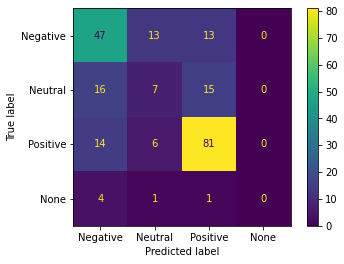

In [376]:
disp.plot()
plt.show()

Does quite poorly predicting Neutral sentiment